In [1]:
from homomorphic import homomorphic
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path = file_path = os.path.abspath('')
file = os.path.join(path, "star_tracker_image.jpeg")

In [3]:
img = cv2.imread(file)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

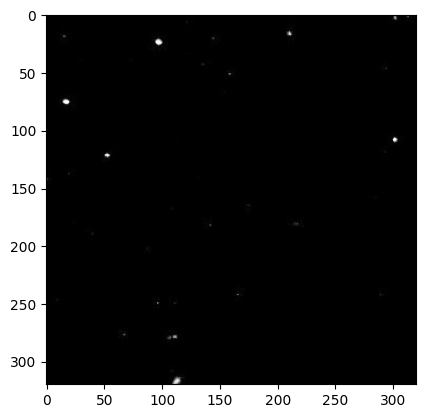

In [36]:
plt.imshow(gray, cmap='gray')

In [35]:

gamma_l = 0.1   # Gamma for low frequency
gamma_h = 2   # Gamma for high frequency
c = 1.0         # Cutoff frequency
out = homomorphic(gray, gamma_l, gamma_h, c)

/root/starhash/data/homomorphic.py:8: RuntimeWarning: divide by zero encountered in log
  img_log = np.log(img + 1)
/root/starhash/data/homomorphic.py:27: RuntimeWarning: invalid value encountered in multiply
  g_shift = H * f_shift
/root/starhash/data/homomorphic.py:37: RuntimeWarning: invalid value encountered in cast
  out = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


In [31]:
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

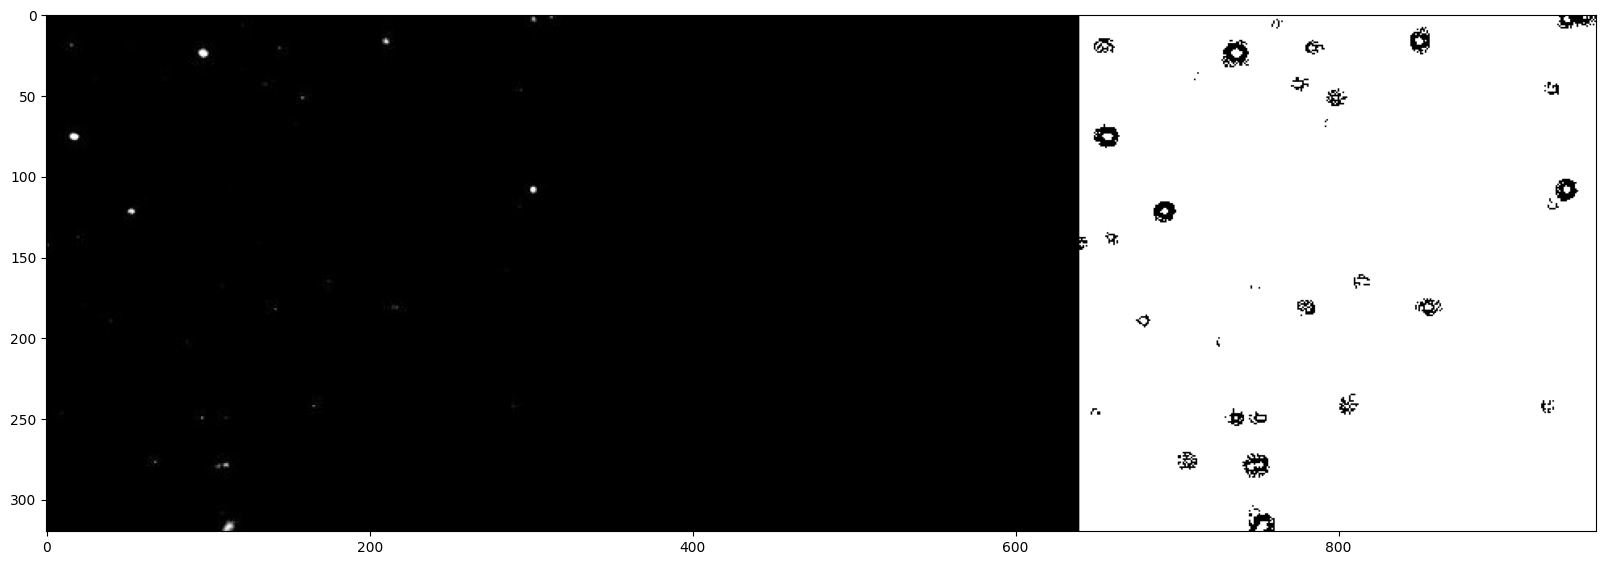

In [32]:
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack([gray, out, thresh]), "gray")

In [40]:
th2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,15,2)
th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,2)

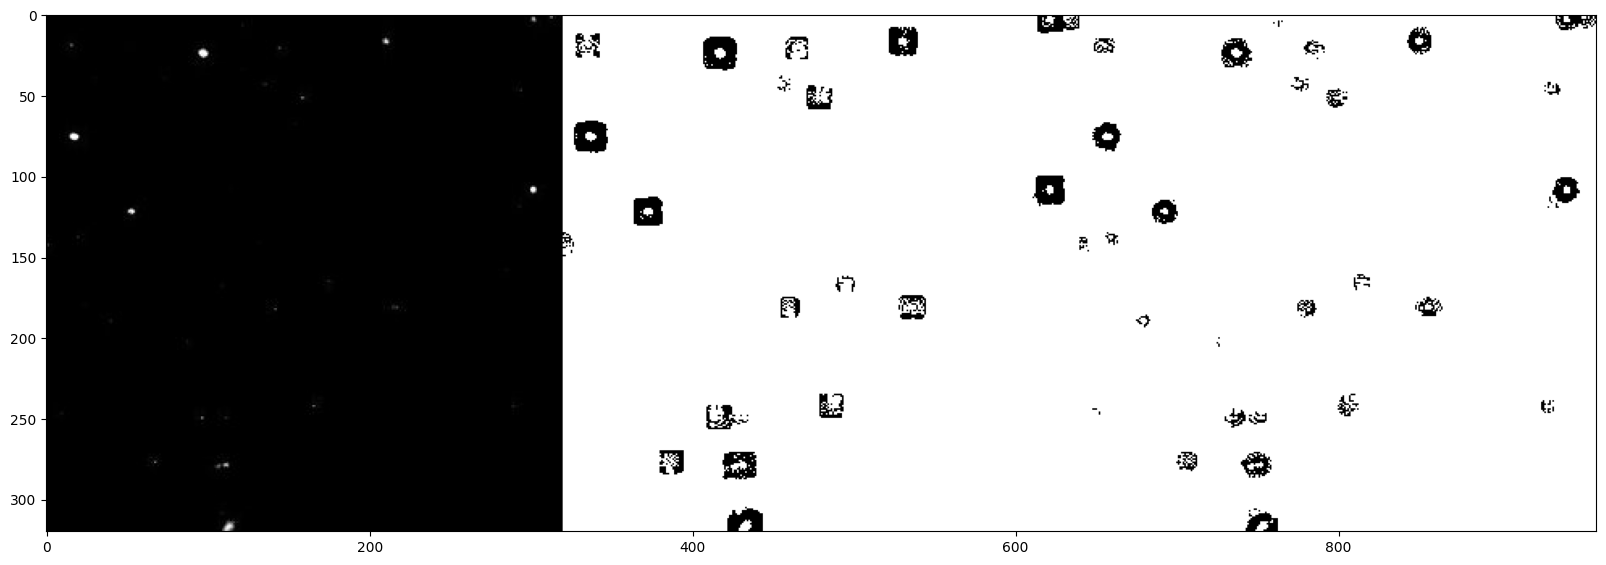

In [41]:
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack([gray, th2, th3]), "gray")

In [42]:
ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur = cv2.GaussianBlur(gray,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

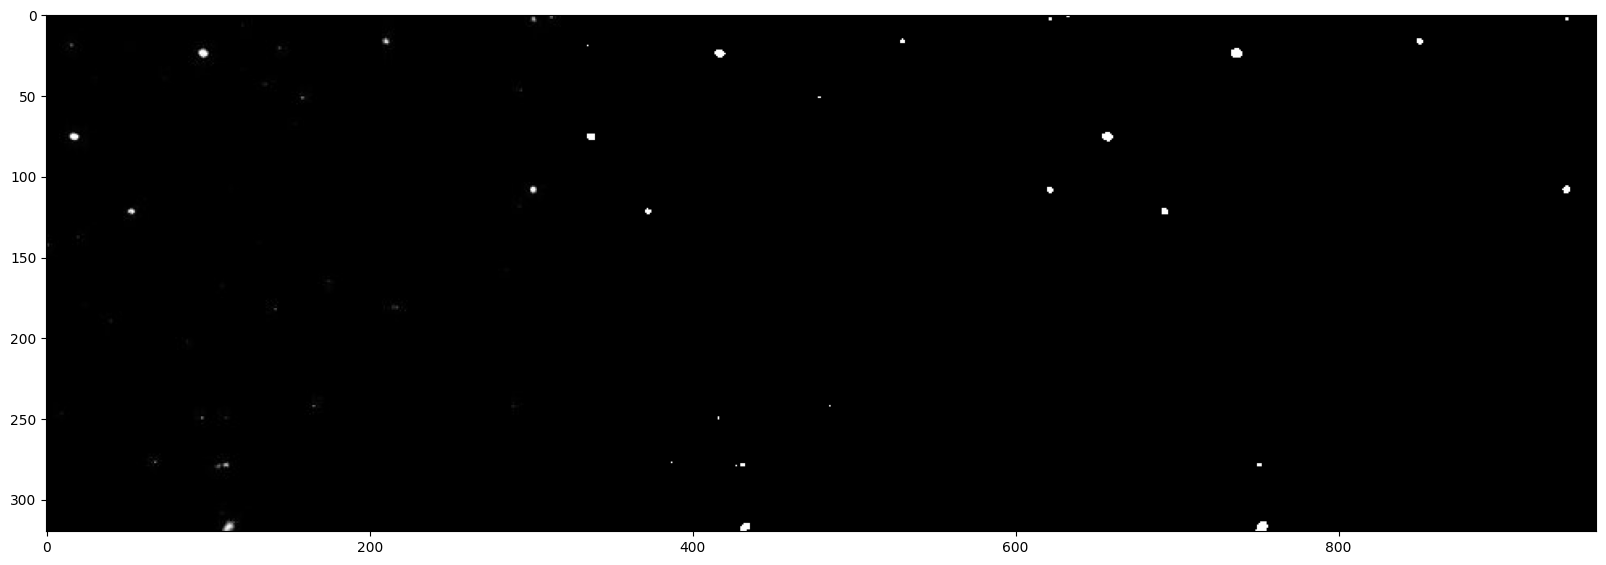

In [43]:
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack([gray, th2, th3]), "gray")

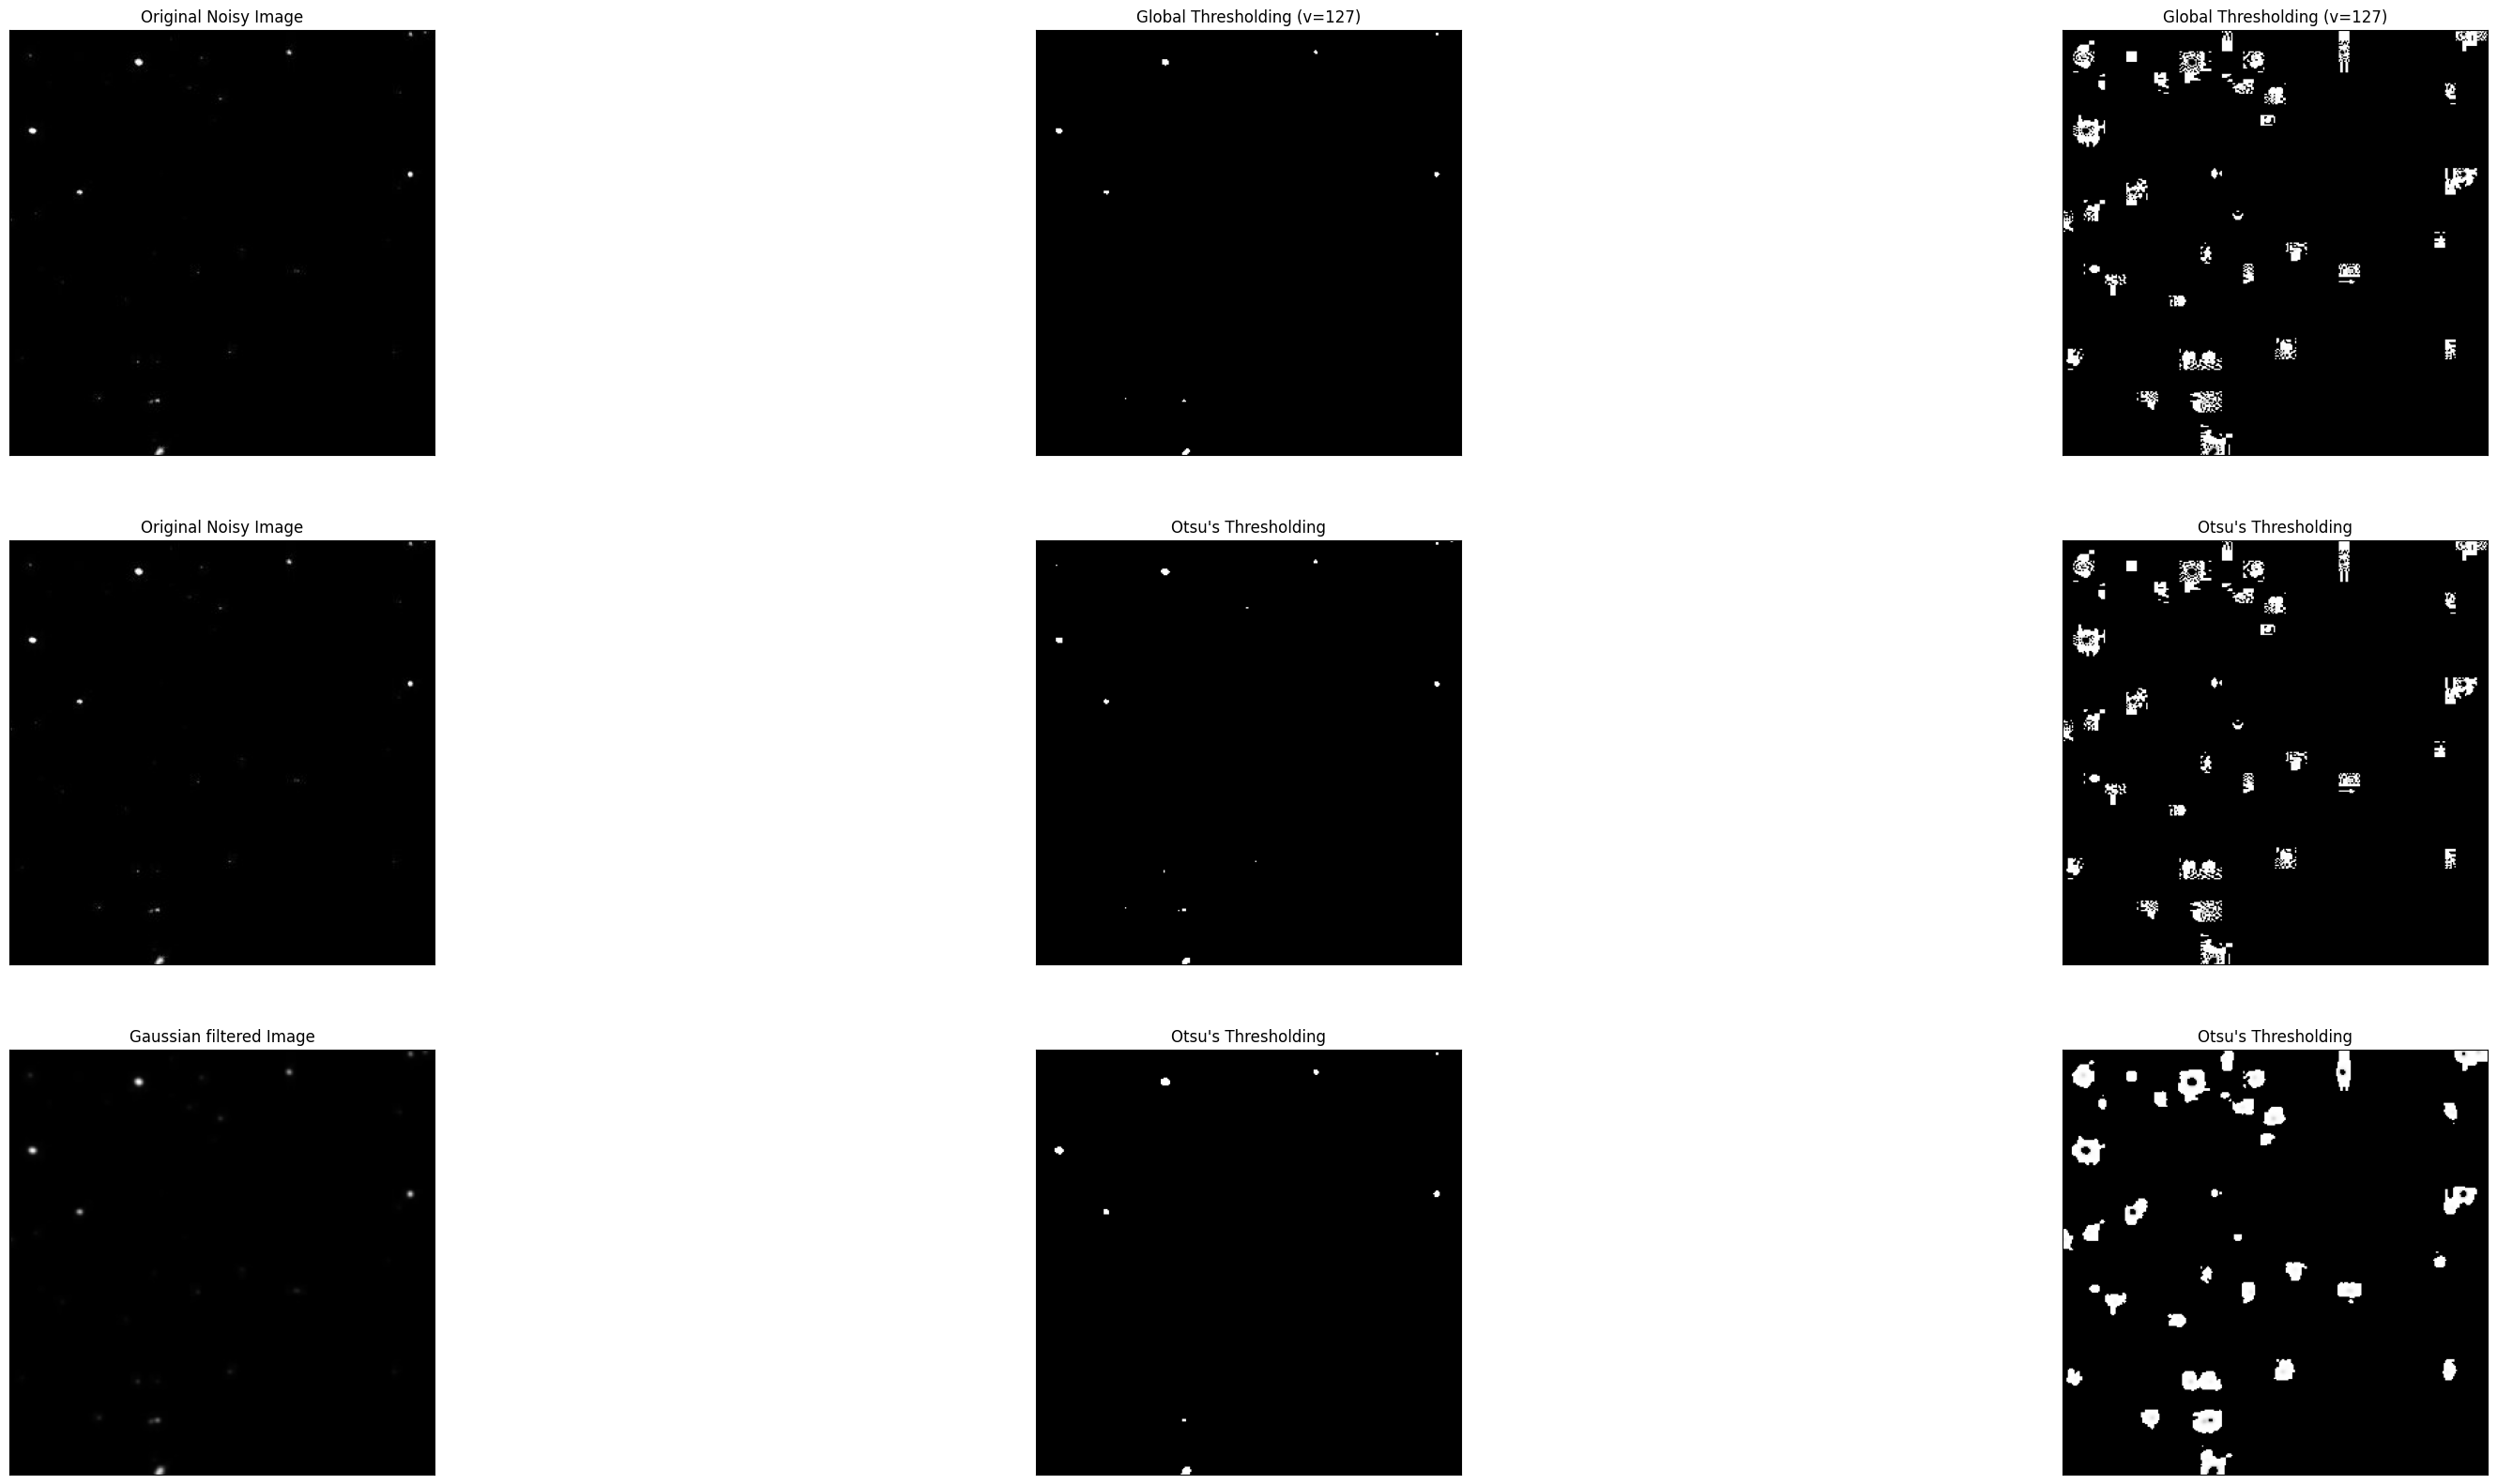

In [53]:
import cv2 as cv

img = gray

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

plt.figure(figsize=(40, 20))
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3] * ~images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [55]:
import torch
import torchvision.transforms as transforms
from PIL import Image

In [56]:
# Load the pre-trained U-Net model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

/root/Envs/cv/lib/python3.8/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [57]:
# Set the model to evaluation mode
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [107]:
# Load the input image and apply transformations
image = Image.open("large_star_image.JPG")
gray_image = image.convert('L') # convert the image to grayscale
image_tensor = transform(gray_image)
image_tensor = image_tensor.unsqueeze(0)

RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

In [59]:
# Pass the image through the model
with torch.no_grad():
    output = model(image_tensor)

In [87]:
output2 = output.squeeze().numpy()

In [73]:
# Convert the output to a binary mask
mask = torch.sigmoid(output) > 0.5


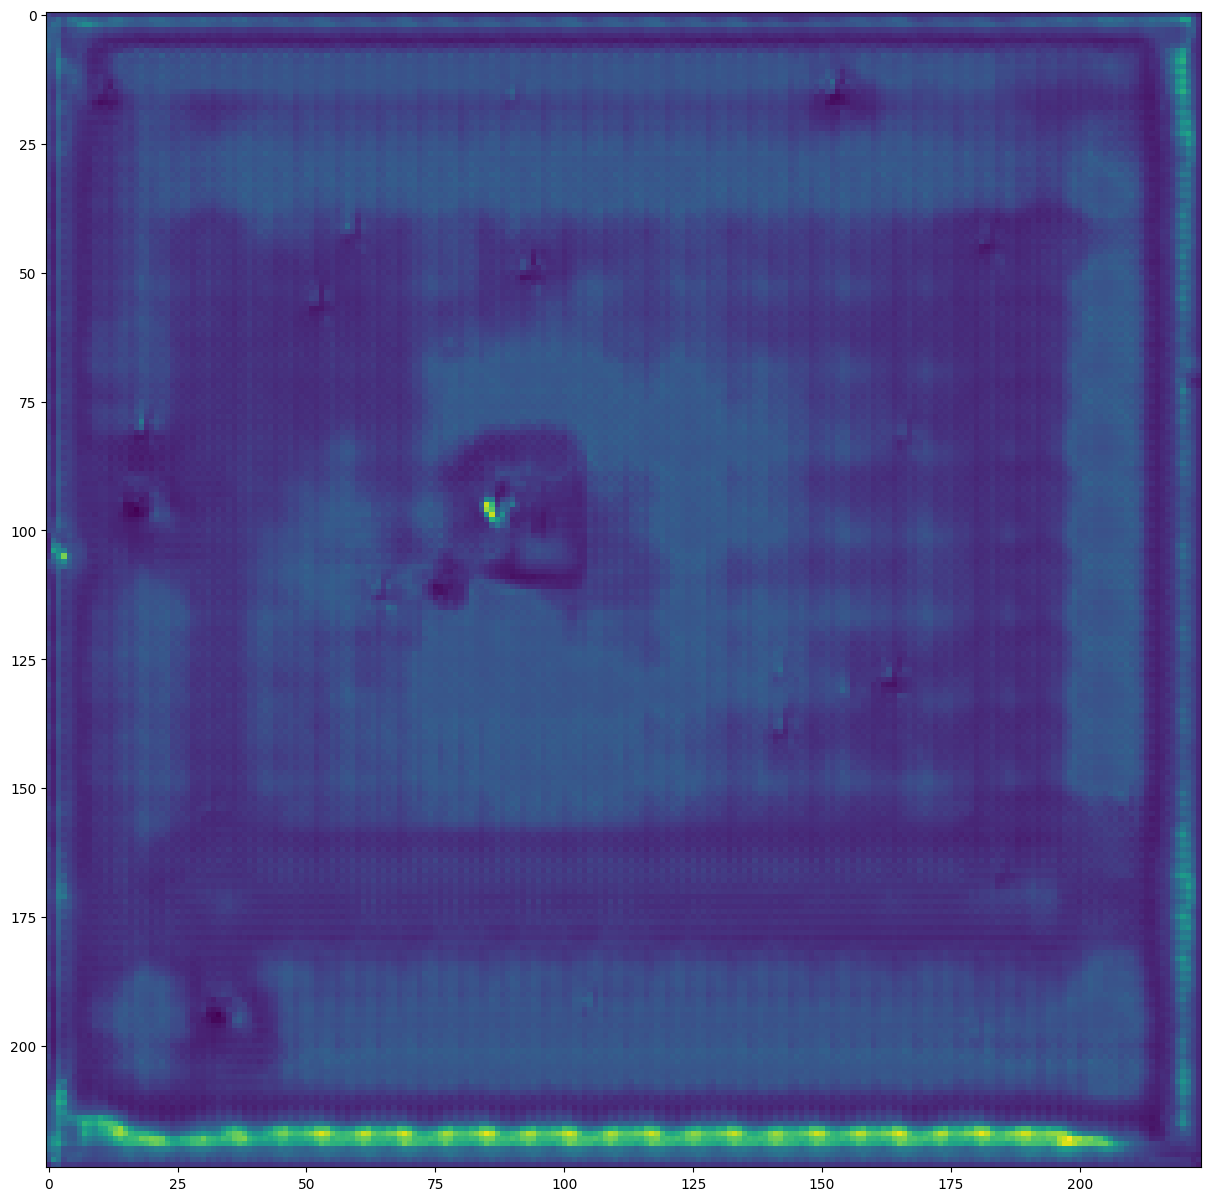

In [91]:
mask_array = torch.sigmoid(output).squeeze().cpu().numpy()
mask_min = mask_array.min()
mask_max = mask_array.max()
mask_array = ((mask_array - mask_min) / (mask_max - mask_min)) * 255
mask_array = mask_array.astype(np.uint8)
plt.imshow(mask_array)

In [95]:
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)

In [102]:
# Resize the original image tensor to the same size as the binary mask tensor
resized_image_tensor = torch.nn.functional.interpolate(image_tensor, size=(mask_array.shape[0], mask_array.shape[1]), mode='bilinear', align_corners=False)

# Convert the resized image tensor to a NumPy array and normalize it to the range of 0-255
#resized_image_array = (resized_image_tensor.squeeze().permute(1,2,0).numpy() * 255).astype(np.uint8)
resized_image_array = (resized_image_tensor.squeeze().numpy() * 255).astype(np.uint8)


In [103]:
mask_array.shape

(224, 224)

In [105]:
# Resize the original image tensor to the same size as the binary mask tensor
resized_image_tensor = torch.nn.functional.interpolate(image_tensor, size=(mask_array.shape[0], mask_array.shape[1]), mode='bilinear', align_corners=False)

# Convert the resized image tensor to a NumPy array and normalize it to the range of 0-255
resized_image_array = (resized_image_tensor.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8)

In [106]:
resized_image_array.shape

(224, 224, 3)